# 1. 오늘 배워볼 것은?
 - VGG Network 만들기

# 2. VGG-net 이란?
 - 참고 : http://blog.naver.com/PostView.nhn?blogId=laonple&logNo=221259295035
 - Oxford VGG(Visual Geometry Group)에서 만든 Network이다.
 - VGGNet은 Network의 깊이가 어떤 영향을 주는지 연구를 하기 위해서 설계된 Network이다. 따라서 Convolution kernel 사이즈를 한 사이즈로 정하고 Convolution의 개수를 늘리는 방식으로 테스트를 진행했다.
 - VGG-net은 전부 3 * 3 convolution, stride 1, padding 1으로 이루어져 있다.
 - 이론적으로는 5 * 5 kernel이나 3 * 3 kernel 2개나 성능적으로 동일하지만, VGGNet 팀이 테스트 한 결과 3 * 3 Kernel의 중첩이 더 좋았다. 그 이유는 non-linear 함수인 ReLU가 더 많이 들어가서 decision function이 더 잘 학습되기 때문이다. 
 - 실험 결과 network의 깊이가 깊어질 수록 error가 내려간다. 하지만 19 layer부터는 성능이 나빠지는 것을 알 수 있었다.

# 3. torchvision.models.vgg
 - torchvision의 모듈을 통해 vgg11 ~ vgg19까지 만들 수 있다.
 - 3(RGB) * 224 * 224의 input을 기준으로 만들도록 되어 있다.
 - 오늘 실습을 통해 input size가 다른 경우에 VGG를 적용해 보자!

# 4. VGG Network 만들어 보기!

In [1]:
# 1. 라이브러리 로드
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

In [2]:
# 2. 모델 URL 지정하기 (PyTorch에서 ImageNet 챌린지 데이터셋을 기반으로 pretrain 시켜놓은 모델들)
# 변수 선언
__all__ = [
  'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19',
]

# Pretrain 모델 URL
model_urls = {
  'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
  'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
  'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
  'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
  'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
  'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
  'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
  'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',  
}

In [3]:
# 3. VGG 네트워크 만들어 놓기
class VGG(nn.Module): # nn.Module의 클래스를 상속받아서 이용한다.
  def __init__(self, features, num_classes=1000, init_weights=True): # VGG 네트워크를 만들 때 초기 입력 파라미터로 Convolution(features), 분류 클래스 수, weight initialize 여부를 입력한다.
    super(VGG, self).__init__()
    self.features = features # 파라미터로 받은 값을 self.features로 설정.
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    
    # Classifier : VGG의 Classifier는 fully connected layer 3개로 이루어져 있다.
    self.classifier = nn.Sequential(
      nn.Linear(512 * 7 * 7, 4096), # FC Layer 1. 512 * 7 * 7은 도큐먼트에 적혀있는 기본 사이즈이다. 이와 Image 사이즈가 다르거나, (custom layer 등을 이용해서) Convolution의 결과 output이 다른 경우 이 부분을 수정해 줘야 한다!
      nn.ReLU(True),
      nn.Dropout(),
      nn.Linear(4096, 4096), # FC Layer 2
      nn.ReLU(True),
      nn.Dropout(),
      nn.Linear(4096, num_classes), # FC Layer 3
    )
    
    # weight initialize
    if init_weights:
      self._initialize_weights()
      
  # Forward 정의
  def forward(self, x):
    x = self.features(x) # Convolution
    x = self.avgpool(x) # AvgPool
    x = x.view(x.size(0), -1) # 일렬로 펼치기
    x = self.classifier(x) # FC Layer
    return x
    
  # 모듈 내용 별로 initialize weights 정의
  def _initialize_weights(self):
    for m in self.modules(): # 모듈을 하나씩 꺼내 봤을 때,
      if isinstance(m, nn.Conv2d): # 만약 m이 Convolution이면
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # kaining_normal_로 filter의 weight를 초기화를 하라
        if m.bias is not None: # VGG Net에서는 bias 값이 0이여야 하므로
          nn.init.constant_(m.bias, 0) # m.bias를 0으로 초기화
      elif isinstance(m, nn.BatchNorm2d): # 만약 m이 BatchNorm이면
        nn.init.constant_(m.weight, 1) # weight는 전부 1로, bias는 전부 0으로 초기화
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear): # 만약 m이 nn.Linear이면
        nn.init.normal_(m.weight, 0, 0.01) # 다음과 같이 초기화
        nn.init.constant_(m.bias, 0)
        
  # Convolution Layer(feature)가 쌓이는 구조 정의
def make_layers(cfg, batch_norm=False):
    layers = [] # 레이어를 쌓을 빈 리스트 선언
    in_Channels = 3 # input channel 3
    
    for v in cfg: # cfg에서 하나씩 빼서 v로 이용
      if v == 'M': # cfg에서 빼온 값이 M이면
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)] # MaxPool 추가
      else: # cfg에서 빼온 값이 M이 아니면
        conv2d = nn.Conv2d(in_Channels, v, kernel_size=3, padding=1) # v를 이용해 conv2d 정의
        if batch_norm: # batch_norm = True인 경우
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)] # 이 레이어를 layers 리스트에 추가!
        else: # batch_norm = False인 경우
          layers += [conv2d, nn.ReLU(inplace=True)] # 이 레이어를 layers 리스트에 추가!
        in_channels = v # 중요! in_channels를 v로 바꿔준다. conv 레이어를 통과하고 나면 채널 수가 바뀌기 때문에, 다음 layer의 input에 들어갈 값을 바꿔줘야 한다.
        
    return nn.Sequential(*layers)

In [4]:
# 4. Convolution Layer 쌓을 내용 선언 (make_layers에 넣을 내용)
cfg = { # cfg의 값에 따라 Convolution Layer가 쌓이게 된다.
  'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 이렇게 레이어를 쌓으면 Convolution 8 + Fully Connecyed 3가 나온다. => 11 => vgg11
  'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
  'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #1 3 + 3 = vgg 16
  'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 = vgg 19
  'custom' : [64,64,64,'M',128,128,128,'M',256,256,256,'M'] # 그 외 사용자가 임의로 설정 가능!
}

In [5]:
# 5. 만들어 놓은 VGG 네트워크 이용하여 모델 만들기
# Convolution Layer 만들기
#conv = make_layers(cfg['custom'], batch_norm=True) # Convolution layer를 cfg 중 'custom'에 따라 쌓게 한다. batch norm = True로 설정.  => 이 줄이 있는 이유를 모르겠음
CNN = VGG(make_layers(cfg['custom']), num_classes=10, init_weights=True) # VGG의 파라미터로 Convolution layer(feature), class 개수, weights initialize를 설정하여 VGG 모델(CNN)을 만든다.
CNN

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

# 5. VGG Network를 실제 데이터에 이용하기 전에
 - 주피터노트북을 Text로 만들어서 이름을 vgg.py로 설정하고, Pytorch 홈페이지의 Torchvision.model에 있는 VGG를 복사해서 붙여 넣는다.
 - 학습할 위치의 같은 폴더 안에 이 파일이 있어야 VGG를 불러와서 사용할 수 있다!
 - 위의 방법이 귀찮다면 그냥 import torchvision.models.vgg as vgg로도 사용 가능하다.

# 6. CIFAR10 데이터에 VGG 적용하기

In [6]:
# 1. 라이브러리 로드
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [7]:
# 2. 비스돔 이용
import visdom

vis = visdom.Visdom()
vis.close(env="main") # main에 켜져있는게 있다면 다 끈다.

Setting up a new session...


''

In [8]:
# 3. loss tracker 정의
def loss_tracker(loss_plot, loss_value, num):
  vis.line(X=num,
           Y=loss_value,
           win = loss_plot,
           update = 'append'
          )

In [9]:
# 4. device 및 seed 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [10]:
# 5. 데이터 정의
# transform
transform = transforms.Compose(
  [transforms.ToTensor(), # tensor 화
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize

# 데이터 셋 불러오기
trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# 6. visdom에서 이미지 확인
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()
  
dataiter = iter(trainloader)
images, labels = dataiter.next()
vis.images(images/2 + 0.5) # visdom에 이미지를 띄운다.

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

truck   dog horse truck


In [12]:
# 7. VGG 네트워크 : 라이브러리 로드
#import vgg   # 오타 같음
import torchvision.models.vgg as vgg # vgg.py를 만들기 귀찮은 경우 이렇게 라이브러리를 불러서 이용해도 된다.

In [13]:
# 8. VGG 네트워크 : Convolution Layer 쌓을 내용 선언 (make_layers에 넣을 내용)
cfg = [32, 32, 'M', 64, 64, 128, 128, 128, 'M', 256, 256, 256, 512, 512, 512, 'M'] # convolution 13 + FC Layer 3 => vgg16!
# 이 네트워크의 아웃풋을 계산해보면, 32 * 32를 MaxPool 3번 하므로 32 => 16 => 8 => 4가 된다. 즉 아웃풋은 4 * 4 이다. 

In [14]:
# 9. VGG 네트워크 : VGG 네트워크 만들어 놓기
class VGG(nn.Module):
  def __init__(self, features, num_classes=1000, init_weights=True): # 파라미터로 Convolution(features), class 수(초기값은 1000이지만, 나중에 10으로 넣을 것임), weight initialize 설정.
    super(VGG, self).__init__()
    self.features = features
    self.classifier = nn.Sequential(
      nn.Linear(512 * 4 * 4, 4096), # 수정! Conv의 아웃풋을 계산 해 보면 4 * 4 이므로 거기에 맞게 수정했다.
      nn.ReLU(True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(True),
      nn.Dropout(),
      nn.Linear(4096, num_classes),
    )
    if init_weights:
      self._initialize_weights()
      
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x
    
  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

In [15]:
# 10. VGG 네트워크 : 만들어 놓은 VGG 네트워크 이용하여 모델 만들기
vgg16 = VGG(vgg.make_layers(cfg), 10, True).to(device) # Convolution(feature), Class 수, weight initialize를 설정해서 모델 정의. 

# 만든 VGG 모델에 오류 없나 테스트하기
a = torch.Tensor(1, 3, 32, 32).to(device)
out = vgg16(a)
print(out)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward>)


In [16]:
# 11. VGG 네트워크 : Loss, Optimizer, Lr 설정
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9)

# NEW! lr을 고정해 놓지 않고 학습에 따라 lr을 조금씩 감소시키며 학습하는 방법이다. 정밀한 학습에 도움이 된다.
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) # 5번의 step마다 Optimizer의 lr에 0.9를 곱해 준다.

# loss를 plot으로 만들기
loss_plt = vis.line(Y=torch.Tensor(1).zero_(), opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

In [17]:
# 12. VGG 네트워크 : 학습하기
print(len(trainloader))
epochs = 50

for epoch in range(epochs):
    running_loss = 0.0
    lr_sche.step() # epoch이 5번 돌 때마다 lr이 0.9배씩 줄어든다.
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 30 == 29: # 30회마다 loss tracker!
            loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch * len(trainloader)]))  
            print('[%d, %5d] loss: %3.f' %(epoch+1, i+1, running_loss / 30))
            running_loss = 0.0

print('Finished Training')

98


/home/cloudera/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,    30] loss:   2
[1,    60] loss:   2
[1,    90] loss:   2
[2,    30] loss:   2
[2,    60] loss:   2
[2,    90] loss:   2
[3,    30] loss:   2
[3,    60] loss:   2
[3,    90] loss:   2
[4,    30] loss:   2
[4,    60] loss:   2
[4,    90] loss:   2
[5,    30] loss:   2
[5,    60] loss:   2
[5,    90] loss:   2
[6,    30] loss:   1
[6,    60] loss:   1
[6,    90] loss:   1
[7,    30] loss:   1
[7,    60] loss:   1
[7,    90] loss:   1
[8,    30] loss:   1
[8,    60] loss:   1
[8,    90] loss:   1
[9,    30] loss:   1
[9,    60] loss:   1
[9,    90] loss:   1
[10,    30] loss:   1
[10,    60] loss:   1
[10,    90] loss:   1
[11,    30] loss:   1
[11,    60] loss:   1
[11,    90] loss:   1
[12,    30] loss:   1
[12,    60] loss:   1
[12,    90] loss:   1
[13,    30] loss:   1
[13,    60] loss:   1
[13,    90] loss:   1
[14,    30] loss:   1
[14,    60] loss:   1
[14,    90] loss:   1
[15,    30] loss:   1
[15,    60] loss:   1
[15,    90] loss:   1
[16,    30] loss:   1
[16,    60] los

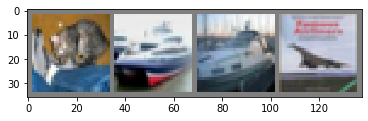

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [18]:
# 13. VGG 네트워크 : 시각화를 통해 Test 데이터 잘 맞추나 확인하기
dataiter = iter(testloader)
images, labels = dataiter.next()

# GT 이미지 4개 출력해보기
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# GT와 outputs의 결과가 같나 확인하기
outputs = vgg16(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [19]:
# 14. VGG 네트워크 : Test 셋으로 모델 평가하기
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    imgaes, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = vgg16(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' %(100*correct / total)) # 정확도 76%

Accuracy of the network on the 10000 test images: 9 %
